# EN.605.646.81: Natural Language Processing, Fall 2024
## Applied and Computational Mathematics
## Johns Hopkins University
## Andres Davila Corujo

### Lab 2: Language Models

#### Synopsis

In this lab we looked at naive language models, training to predict the next letter and words given n letters and words. We started by training a unigram letter model and worked our way up to a 5-gram letter model. When dealing with models that have a more context I noticed their predictive power also increased yet not by a lot - they plateaued. 

Using the models developed we tackled language classification and gender detection. In this report we show how/why a word language model performed poorly when compared to a letter language model. We also explored training word language models using corpora provided by NLTK in hopes of obtaining word models with better predictive powers. Unfortunately, this was not the case as the model's accuracy did not improve drastically.

In conclusion, I'd say Markov language models can be great at mining the corpora for tasks such as the ones we tackle in this report. This approach could allow us to stem into other NLP tasks such as sentiment analysis and topic modeling given this approach essentially builds a frequency distribution. Simple, yet effective for understanding corpora.

(a) Simple Character LM

In [43]:
import os
from lab2.charlm import *

subtitles = os.path.abspath('./lab2/subtitles.txt')

order = 4
four_gram_lm = train_char_lm(subtitles, order)

In [44]:
print_probs(four_gram_lm, 'atio')

[('n', 0.9940436161014506),
 (' ', 0.00220962628494572),
 ('.', 0.0013930252665962147),
 (',', 0.0009607070804111826),
 ('?', 0.0003362474781439139),
 ("'", 0.00024017677010279565),
 ('u', 0.00019214141608223654),
 ('"', 0.0001441060620616774),
 ('s', 0.0001441060620616774),
 ('-', 9.607070804111827e-05),
 ('!', 4.8035354020559135e-05),
 (':', 4.8035354020559135e-05),
 ('m', 4.8035354020559135e-05),
 ('p', 4.8035354020559135e-05),
 ('r', 4.8035354020559135e-05)]


In [45]:
print_probs(four_gram_lm, 'nivi')

[('n', 0.8), ('e', 0.1), ('s', 0.1)]


In [46]:
print_probs(four_gram_lm, 'supe')

[('r', 0.9992144540455616), ('s', 0.0007855459544383347)]


In [52]:
import pprint
# generate random text
character_length = 80
for i in range(3):
    sentence = generate_text(four_gram_lm, 4, character_length)
    pprint.pp(f'{i}.' + generate_text(four_gram_lm, order, 80))
    print()

('0.All right hay Lauren.\n'
 'Any the courself.\n'
 'He say I meal?\n'
 'Take it a battempt my is ')

("1.It for love you're and you are your corner writies?\n"
 'None ther.\n'
 "- Uh, 'cause work")

('2.- Shh!\n'
 '- How does to longer and here.\n'
 "I'm sorry and like were is father really c")



(b) Perplexity

In [53]:
import math

def perplexity(text, lm, order):
    # Pad the input with "~" chars.  This handles the case where order > len(text).
    pad = "~" * order
    data = pad + text
    # This is a stub.
    N = len(text)   # total number of tokens
    probs = []
    index = 0
    while index < N:
        hist = data[index: index+order] # get the history in chunks of size 'order'
        """ 
        get the other next character to obtain probability
        of next_char given the hist
        """
        next_char = data[index+order]    
        # found flag
        found = False
        if hist in lm:
            for character, prob in lm[hist]:
                # search for matching character in model
                if character == next_char:
                    # extract probability in log space
                    probs.append(math.log(prob))
                    found = True

        if not found: # if character was not found
            probs.append(float('inf'))
        index+=1
    probs = sum(probs)
    return math.exp(probs)**(-1/N)

In [54]:
perplexity('The boy loves his mother', four_gram_lm, 4)

3.909190367374623

In [55]:
# train new 5-gram model
order = 5
five_gram_lm = train_char_lm(subtitles, order)


In [56]:
# get perplexity for each sample
print('PERPLEXITY SCORES')
display('The student loves homework: {}'.format(perplexity('The student loves homework', five_gram_lm, order)))
display('The yob loves homework: {}'.format(perplexity('The yob loves homework', five_gram_lm, order)))
display('It is raining in London: {}'.format(perplexity('It is raining in London', five_gram_lm, order)))
display('asdfjkl;qwerty: {}'.format(perplexity('asdfjkl;qwerty', five_gram_lm, order)))

PERPLEXITY SCORES


'The student loves homework: 3.94295503931033'

'The yob loves homework: 0.0'

'It is raining in London: 3.649875707020062'

'asdfjkl;qwerty: 0.0'

We can see some sentences have a perplexity score of 0. This is due to the use of positive inf for the zero probability. If we implement any type of smoothing this effect should be obviated

(c) Naive Smoothing

In [84]:
import math

def smoothed_perplexity(text: str, lm: dict, order: int):
    # Pad the input with "~" chars.  This handles the case where order > len(text).
    pad = "~" * order
    data = pad + text
    # This is a stub.
    N = len(text)   # total number of tokens
    probs = []

    for index in range(N):
        hist: list = data[index: index+order] # get the history in chunks of size 'order'
        """ 
        get the other next character to obtain probability
        of next_char given the hist
        """
        next_char: str = data[index+order]
        # found flag
        found = False
        for character, prob in lm.get(hist, []):
            # search for matching character in model
            if character == next_char:
                # extract probability in log space
                probs.append(math.log(prob))
                found = True

        if not found: # if character was not found
            probs.append(1.0e-7)

    probs = sum(probs)
    return math.exp(probs)**(-1/N)

In [58]:
# get perplexity for each sample
print('PERPLEXITY SCORES')
display('The student loves homework: {}'.format(smoothed_perplexity('The student loves homework', five_gram_lm, order)))
display('The yob loves homework: {}'.format(smoothed_perplexity('The yob loves homework', five_gram_lm, order)))
display('It is raining in London: {}'.format(smoothed_perplexity('It is raining in London', five_gram_lm, order)))
display('asdfjkl;qwerty: {}'.format(smoothed_perplexity('asdfjkl;qwerty', five_gram_lm, order)))

PERPLEXITY SCORES


'The student loves homework: 3.94295503931033'

'The yob loves homework: 2.9702585208423953'

'It is raining in London: 3.649875707020062'

'asdfjkl;qwerty: 2.1138816358644523'

As we can see with a naive smoothing perplexity scores are no longer reduced to 0

(d) Language Identification

In [94]:
# training 5 models
import tqdm
ORDER = 10
print('[*] Training models...')
letter_models = {}
for order in tqdm.tqdm(range(ORDER)):
    letter_models[order] = {
        'da': train_char_lm(os.path.abspath('./lab2/da.train.txt'), order),
        'de': train_char_lm(os.path.abspath('./lab2/de.train.txt'), order),
        'en': train_char_lm(os.path.abspath('./lab2/en.train.txt'), order),
        'fr': train_char_lm(os.path.abspath('./lab2/fr.train.txt'), order),
        'it': train_char_lm(os.path.abspath('./lab2/it.train.txt'), order),
        'nl': train_char_lm(os.path.abspath('./lab2/nl.train.txt'), order)
    }
print('...models trained!')

[*] Training models...


100%|██████████| 10/10 [00:54<00:00,  5.47s/it]

...models trained!


In [61]:
# load test file
TEST_PATH = os.path.abspath('./lab2/test.txt')
test_data = open(TEST_PATH, 'r', encoding='utf-8').readlines()

### Run each model on the first sentence of the test data

<Axes: xlabel='lang', ylabel='score'>

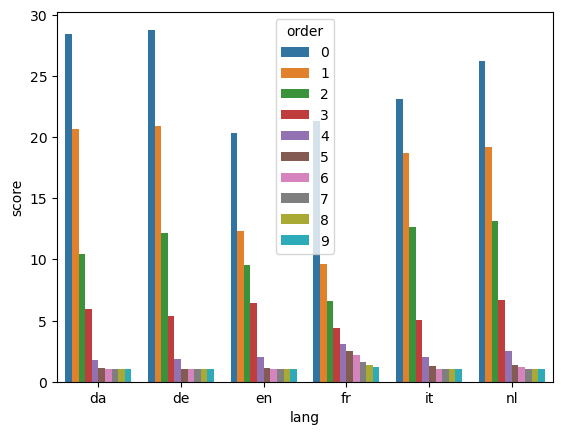

In [95]:
# get pred for all unigram models for first sentence
history = {
    'sentence_id': [],
    'perplexity_score': [],
    'language_pred': [],
    'language_truth': []
}

text = test_data[0]
# history
model_scores = {
    'order': [],
    'score': [],
    'lang': []
}

# iterate over all models
for order in range(ORDER):
    ngram_model = letter_models[order]
    # iterate over all languages for this ngram model
    for model_lang, model in ngram_model.items():
        try:
            score = smoothed_perplexity(text, model, order=order)
        except ZeroDivisionError as e:
            score = 0

        model_scores['lang'].append(model_lang)
        model_scores['score'].append(score)
        model_scores['order'].append(order)



import pandas as pd
import seaborn as sns

sns.barplot(pd.DataFrame(model_scores), x='lang', y='score', hue='order')

We can see each language model yields a lower perplexity score as they obtain more context. This is indicative that models of higher order will yield better results, i.e. higher accuracy scores. Let's test it out.

In [96]:
import pandas as pd
RESULTS=pd.DataFrame()

In [97]:
def test_ngram_model(test_data: list[str], order: int, ngram_models: dict[dict]):
    """
    Test an ngram model for language detection. The function 
    takes in a list of tab deliniated sentences where the left side 
    defines the language and the right side defines the sentence.
    
    Once the function runs through all the languages, it picks the 
    one with the lowest perplexity score.
    """
    history = {
        'sentence_id': [],
        'perplexity_score': [],
        'language_pred': [],
        'language_truth': [],
        'order': []
    }
    for sentence_index, test in enumerate(test_data):
        # get the text
        language = test.split('\t')[0]
        text = test.split('\t')[1]

        # iterate over the unigram models
        model_scores  = []
        for model_lang, model in ngram_models.items():
            try:
                score = smoothed_perplexity(text, model, order=order)
            except ZeroDivisionError as e:
                score = 0

            model_scores.append({
                'model': model_lang,
                'score': score
            })
        model_scores.sort(key=lambda x: x['score'])
        best_model = model_scores[0]
        history['sentence_id'].append(sentence_index+1)
        history['perplexity_score'].append(best_model.get('score'))
        history['language_pred'].append(best_model.get('model'))
        history['language_truth'].append(language)
        history['order'].append(order)
    
    import pandas as pd
    ngram_metrics = pd.DataFrame(history)
    return ngram_metrics

def get_metrics(metrics: pd.DataFrame):
    """
    Print metrics for a given test suite
    """
    import numpy as np
    languages = ['da', 'de', 'en', 'fr', 'it', 'nl']
    for language in languages:
        local_metrics = metrics[metrics['language_truth'] == language]
        accuracy = np.mean(local_metrics['language_pred'] == local_metrics['language_truth'])
        print(f"{language} - {accuracy*100}% - {accuracy*len(local_metrics)} / {len(local_metrics)}")

#### Test Results for All Models

In [99]:
LANG_RESULTS = pd.DataFrame()
for order in tqdm.tqdm(range(ORDER)):
    ngram_metrics = test_ngram_model(test_data=test_data, order=order, ngram_models=letter_models[order])
    get_metrics(ngram_metrics)
    LANG_RESULTS = pd.concat([LANG_RESULTS, ngram_metrics])
    

 10%|█         | 1/10 [00:01<00:16,  1.80s/it]

da - 19.5% - 39.0 / 200
de - 49.0% - 98.0 / 200
en - 87.0% - 174.0 / 200
fr - 19.0% - 38.0 / 200
it - 74.0% - 148.0 / 200
nl - 83.0% - 166.0 / 200


 20%|██        | 2/10 [00:02<00:10,  1.30s/it]

da - 80.0% - 160.0 / 200
de - 95.0% - 190.0 / 200
en - 95.5% - 191.0 / 200
fr - 73.5% - 147.0 / 200
it - 95.0% - 190.0 / 200
nl - 95.5% - 191.0 / 200


 30%|███       | 3/10 [00:03<00:07,  1.05s/it]

da - 83.5% - 167.0 / 200
de - 92.5% - 185.0 / 200
en - 98.0% - 196.0 / 200
fr - 86.0% - 172.0 / 200
it - 96.5% - 193.0 / 200
nl - 95.0% - 190.0 / 200


 40%|████      | 4/10 [00:04<00:05,  1.12it/s]

da - 22.0% - 44.0 / 200
de - 41.0% - 82.0 / 200
en - 51.5% - 103.0 / 200
fr - 52.0% - 104.0 / 200
it - 68.0% - 136.0 / 200
nl - 23.0% - 46.0 / 200


 50%|█████     | 5/10 [00:04<00:03,  1.26it/s]

da - 0.0% - 0.0 / 200
de - 0.0% - 0.0 / 200
en - 0.0% - 0.0 / 200
fr - 0.0% - 0.0 / 200
it - 0.0% - 0.0 / 200
nl - 0.0% - 0.0 / 200


 60%|██████    | 6/10 [00:05<00:02,  1.41it/s]

da - 0.0% - 0.0 / 200
de - 0.0% - 0.0 / 200
en - 0.0% - 0.0 / 200
fr - 0.0% - 0.0 / 200
it - 0.0% - 0.0 / 200
nl - 0.0% - 0.0 / 200


 70%|███████   | 7/10 [00:05<00:01,  1.57it/s]

da - 0.0% - 0.0 / 200
de - 0.0% - 0.0 / 200
en - 0.0% - 0.0 / 200
fr - 0.0% - 0.0 / 200
it - 0.0% - 0.0 / 200
nl - 0.0% - 0.0 / 200


 80%|████████  | 8/10 [00:06<00:01,  1.73it/s]

da - 0.5% - 1.0 / 200
de - 0.0% - 0.0 / 200
en - 0.0% - 0.0 / 200
fr - 0.0% - 0.0 / 200
it - 0.0% - 0.0 / 200
nl - 0.0% - 0.0 / 200


 90%|█████████ | 9/10 [00:06<00:00,  1.86it/s]

da - 0.0% - 0.0 / 200
de - 0.0% - 0.0 / 200
en - 0.0% - 0.0 / 200
fr - 0.0% - 0.0 / 200
it - 0.0% - 0.0 / 200
nl - 0.0% - 0.0 / 200


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]

da - 0.0% - 0.0 / 200
de - 0.0% - 0.0 / 200
en - 0.5% - 1.0 / 200
fr - 0.0% - 0.0 / 200
it - 0.0% - 0.0 / 200
nl - 0.0% - 0.0 / 200


Wow those aren't great results given high ngram models. Let's visualize the perplexity scores then.

<Axes: xlabel='language_truth', ylabel='perplexity_score'>

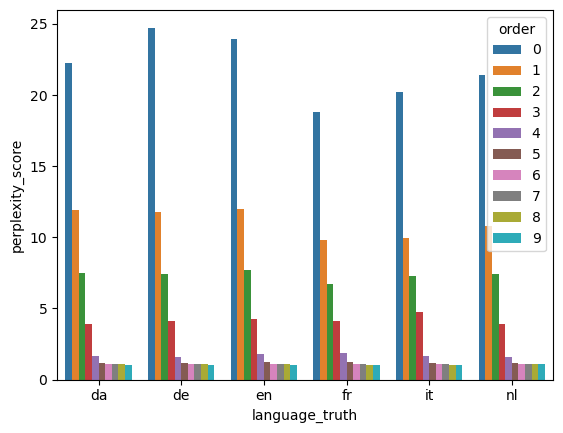

In [100]:
import seaborn as sns
perplexity_by_language = LANG_RESULTS[['language_truth', 'order', 'perplexity_score']].groupby(['language_truth', 'order']).mean()
perplexity_by_language['language_truth'] = [lang[0] for lang in perplexity_by_language.index]
perplexity_by_language['order'] = [lang[1] for lang in perplexity_by_language.index]

sns.barplot(data=perplexity_by_language, x='language_truth', y='perplexity_score', hue='order')

We can see how the 10-gram model (order of 9+1) gives the lowest perplexity score for each language. This makes sense as a lower perplexity score describes models with a higher predictive power. Lower models tend to be very volatile given they are basically performing zero-shot predictions, hence a model's order and its perplexity score have a negative correlation.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

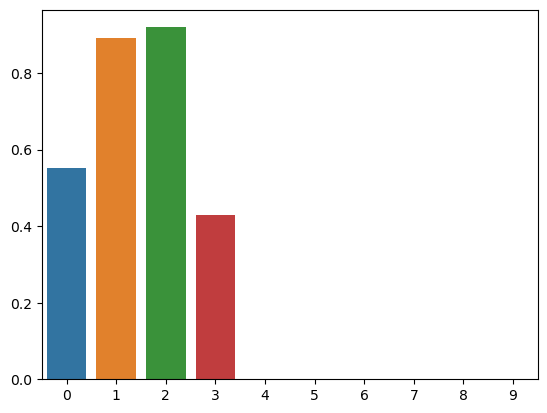

In [101]:
import numpy as np
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': []
}

by_order = LANG_RESULTS[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

for order in by_order.index:
    truths: np.ndarray = by_order[by_order.index == order]['language_truth'].values
    preds: np.ndarray = by_order[by_order.index == order]['language_pred'].values
    truths: list = truths[0]
    preds: list = preds[0]
    running_accuracy = 0
    for i in range(len(truths)):
        running_accuracy += int(truths[i] == preds[i])
    accuracy = running_accuracy / len(truths)
    order_results['order'].append(order)
    order_results['accuracy'].append(accuracy)

sns.barplot(data=order_results, x='order', y='accuracy')

Here we can see a trigram model performs best with a fourgram model dropping its accuracy significantly. This goes to show that a model yielding low perplexity scores is not necessarily indicative of an accurate one.

The reason we have 0 accuracy, or very poor, is due to the language model not having the history to predict provide a prediction. Given our naive approach, this happens due to our model not having enough training data. One would say we could provide more data and call it a day, but that's not always the solution. If we add more data and make this more expensive, there's no guarantee the model will perform when dealing with unforeseen data.

This is an aggregate representation, not taking into consideration the accuracy of a model by language. Let's see how that looks like.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

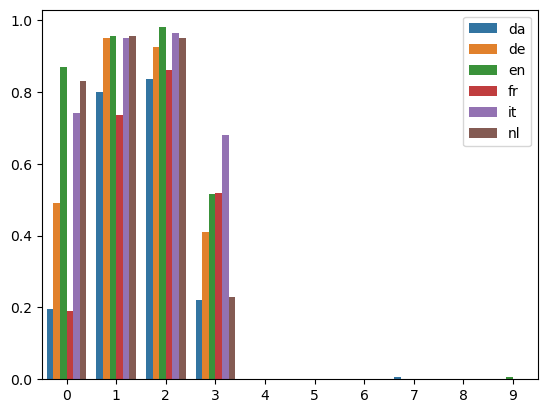

In [102]:
# break down accuracy by order and language
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': [],
    'language': []
}

languages = ['da', 'de', 'en', 'fr', 'it', 'nl']

for order in by_order.index:
    for language in languages:
        language_results = LANG_RESULTS[LANG_RESULTS['language_truth'] == language]
        by_order = language_results[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

        truths: np.ndarray = by_order[by_order.index == order]['language_truth'].values
        preds: np.ndarray = by_order[by_order.index == order]['language_pred'].values
        truths: list = truths[0]
        preds: list = preds[0]
        running_accuracy = 0
        for i in range(len(truths)):
            running_accuracy += int(truths[i] == preds[i])
        accuracy = running_accuracy / len(truths)
        order_results['order'].append(order)
        order_results['accuracy'].append(accuracy)
        order_results['language'].append(language)

sns.barplot(data=order_results, x='order', y='accuracy', hue='language')

Here we can see the models perform best for english, italian, and dutch. We can also see bi- and tri-gram models is the sweet spot we want to be for this dataset, yielding higher overall accuracy for each language.

(e) Gender Bias

Let's create two training datasets, one for M and one for F. This is done to make training easier by just passing a reference to a file.

In [103]:
# seperate training data by class
import os
tennis_train_data = open(os.path.abspath('./lab2/tennis.train.txt'), 'r', encoding='utf-8').readlines()
male_tennis_train_data = open(os.path.abspath('./lab2/tennis.train.male.txt'), 'a')
female_tennis_train_data = open(os.path.abspath('./lab2/tennis.train.female.txt'), 'a')
tennis_test_data = open(os.path.abspath('./lab2/tennis.test.txt'), 'r', encoding='utf-8').readlines()

for training_data in tennis_train_data:
    gender = training_data.split('\t')[0]
    text = training_data.split('\t')[1]

    if gender == 'M':
        male_tennis_train_data.write(text)
    if gender == 'F':
        female_tennis_train_data.write(text)

In [105]:
# train 5 models
import tqdm
models = {}
for order in tqdm.tqdm(range(ORDER)):
    models[order] = {
        'm': train_char_lm(os.path.abspath('./lab2/tennis.train.male.txt'), order),
        'f': train_char_lm(os.path.abspath('./lab2/tennis.train.female.txt'), order),
    }

100%|██████████| 10/10 [03:26<00:00, 20.64s/it]


In [36]:
def test_ngram_model(
        test_data: list, 
        order: int, 
        ngram_models: dict
) -> pd.DataFrame:
    """
    Test an ngram model against a list of sentences
    """
    history = {
        'sentence_id': [],
        'perplexity_score': [],
        'gender_pred': [],
        'gender_truth': [],
        'order': []
    }
    for sentence_index, test in enumerate(test_data):
        # get the text
        gender = test.split('\t')[0]
        text = test.split('\t')[1]

        # iterate over the unigram models
        model_scores  = []
        for gender_model, model in ngram_models.items():
            try:
                score = smoothed_perplexity(text, model, order=order)
            except ZeroDivisionError as e:
                score = 0

            model_scores.append({
                'model': gender_model,
                'score': score
            })

        model_scores.sort(key=lambda x: x['score'])
        best_model = model_scores[0]
        history['sentence_id'].append(sentence_index+1)
        history['perplexity_score'].append(best_model.get('score'))
        history['gender_pred'].append(best_model.get('model'))
        history['gender_truth'].append(gender.lower())
        history['order'].append(order)
    
    import pandas as pd
    ngram_metrics = pd.DataFrame(history)
    return ngram_metrics

In [106]:
import pandas as pd

def get_metrics_gender(metrics: pd.DataFrame):
    """
    Print metrics for a given test suite
    """
    import numpy as np
    genders = ['m', 'f']
    for gender in genders:
        local_metrics = metrics[metrics['language_truth'] == gender]
        accuracy = np.mean(local_metrics['language_pred'] == local_metrics['language_truth'])
        print(f"Model {gender} has accuracy {accuracy*100}% with {accuracy*len(local_metrics)} out of {len(local_metrics)}")

In [108]:
# obtain metrics for all 5 models
GENDER_RESULTS = pd.DataFrame()
for order in tqdm.tqdm(range(ORDER)):
    fourgram_metrics = test_ngram_model(
        test_data=tennis_test_data, 
        order=order,
        ngram_models=models.get(order, {})
    )
    GENDER_RESULTS = pd.concat([GENDER_RESULTS, fourgram_metrics])

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


In [109]:
GENDER_RESULTS

,sentence_id,perplexity_score,language_pred,language_truth,order
0,1,20.462310,f,M,0
1,2,20.787650,m,M,0
2,3,22.113956,m,M,0
3,4,24.730183,f,M,0
4,5,19.305490,f,M,0
...,...,...,...,...,...
8209,8210,1.752385,f,M,9
8210,8211,1.688257,f,M,9
8211,8212,1.488845,f,M,9
8212,8213,1.420969,m,M,9


In [110]:
# change column names to match gender
GENDER_RESULTS['gender_pred'] = GENDER_RESULTS['language_pred']
GENDER_RESULTS['gender_truth'] = GENDER_RESULTS['language_truth'].apply(lambda x: x.lower())

In [111]:
GENDER_RESULTS

,sentence_id,perplexity_score,language_pred,language_truth,order,gender_pred,gender_truth
0,1,20.462310,f,M,0,f,m
1,2,20.787650,m,M,0,m,m
2,3,22.113956,m,M,0,m,m
3,4,24.730183,f,M,0,f,m
4,5,19.305490,f,M,0,f,m
...,...,...,...,...,...,...,...
8209,8210,1.752385,f,M,9,f,m
8210,8211,1.688257,f,M,9,f,m
8211,8212,1.488845,f,M,9,f,m
8212,8213,1.420969,m,M,9,m,m


##### Aggregate accuracy by order

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

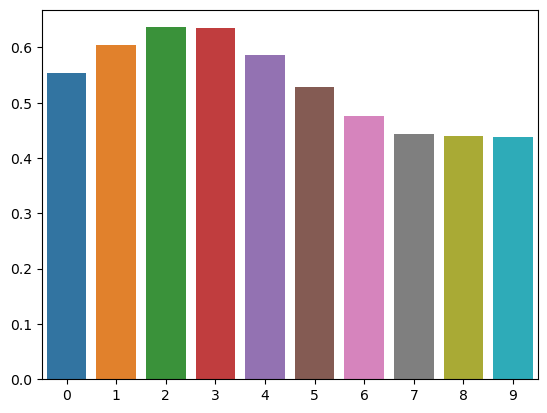

In [112]:
import numpy as np
import seaborn as sns

# get accuracy by order
order_results = {
    'order': [],
    'accuracy': []
}

by_order = GENDER_RESULTS[['gender_truth', 'gender_pred', 'order']].groupby('order').agg(list)

for order in by_order.index:
    truths: np.ndarray = by_order[by_order.index == order]['gender_truth'].values
    preds: np.ndarray = by_order[by_order.index == order]['gender_pred'].values
    truths: list = truths[0]
    preds: list = preds[0]
    running_accuracy = 0
    for i in range(len(truths)):
        running_accuracy += int(truths[i] == preds[i])
    accuracy = running_accuracy / len(truths)
    order_results['order'].append(order)
    order_results['accuracy'].append(accuracy)

sns.barplot(data=order_results, x='order', y='accuracy')

Here we can see a trigram model (order=2) is the best model for this classification task. We can see this isn't the best model with an overall accuracy just above 60%. Maybe using a world lm rather than a character lm would yield better results. Regardless, let's see how accurate each model is per gender.

#### Accuracy by gender and order

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

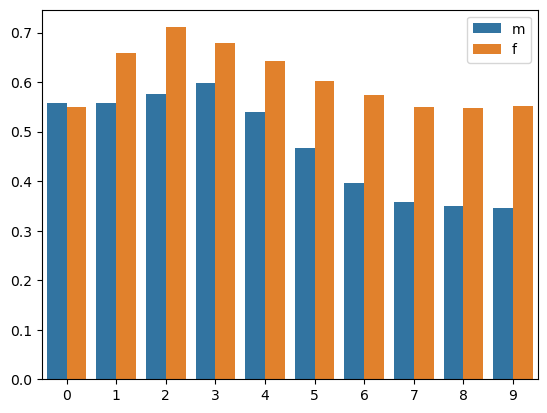

In [113]:
# break down accuracy by order and language
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': [],
    'gender': []
}

genders = ['m', 'f']

for order in by_order.index:
    for gender in genders:
        language_results = GENDER_RESULTS[GENDER_RESULTS['gender_truth'] == gender]
        by_order = language_results[['gender_truth', 'gender_pred', 'order']].groupby('order').agg(list)

        truths: np.ndarray = by_order[by_order.index == order]['gender_truth'].values
        preds: np.ndarray = by_order[by_order.index == order]['gender_pred'].values
        truths: list = truths[0]
        preds: list = preds[0]
        running_accuracy = 0
        for i in range(len(truths)):
            running_accuracy += int(truths[i] == preds[i])
        accuracy = running_accuracy / len(truths)
        order_results['order'].append(order)
        order_results['accuracy'].append(accuracy)
        order_results['gender'].append(gender)

sns.barplot(data=order_results, x='order', y='accuracy', hue='gender')

As we saw before a trigram model (order=2) performs the best for this specific task. In the plot above we can see a model for Females yields better results than a model for Male. My assumption is that the model yields more true positives and/or true negatives than the model for Males.

#### Word LM
Let's see if we can get better results using a word language model

(f) Word LM

In [116]:
import os
import tqdm
import math
import pandas as pd
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize

def train_word_lm(fname, order=4):
    data = open(fname).read()
    sents = data.split('\n')
    lm = defaultdict(Counter)
    for s in tqdm.tqdm(sents):
        s = word_tokenize(s)
        pad = ['~']*order
        for j in range(len(s)):
            pad.extend([s[j]])
            data = pad
            for i in range(len(data)-order):
                history, word = data[i: i+order], data[i+order]
                lm[" ".join(history)][word]+=1

    outlm = {hist:normalize(words) for hist, words in lm.items()}
    return outlm


# define metric
def smoothed_perplexity_word_lm(text: str, lm: dict, order: int):
    # Pad the input with "~" chars.  This handles the case where order > len(text).
    pad = ["~"]*order
    text = word_tokenize(text)

    pad.extend(text)
    data = pad
    # This is a stub.
    N = len(data)   # total number of tokens
    probs = []

    for index in range(len(text)):
        hist: list = data[index: index+order] # get the history in chunks of size 'order'
        hist = " ".join(hist)
        """ 
        get the other next character to obtain probability
        of next_char given the hist
        """
        next_word: str = data[index+order]
        # found flag
        found = False
        for word, prob in lm.get(hist, []):
            # search for matching character in model
            if word == next_word:
                # extract probability in log space
                probs.append(math.log(prob))
                found = True

        if not found: # if character was not found
            probs.append(1.0e-7)

    probs = sum(probs)
    return math.exp(probs)**(-1/N)

# generate random text
# Given a character LM, randomly choose a next character given this history and return it
def generate_word(lm, history, order):
        history = history[-order:]
        history = " ".join(history)
        dist = lm[history]
        x = random()
        for c,v in dist:
            x = x - v
            if x <= 0: return c

# Generate a random text by repeatedly calling generate_word
def generate_text_word(lm, order, nwords=1000):
    history = ["~"] * order
    out = []
    for i in range(nwords):
        word = generate_word(lm, history, order)
        history[-order:].extend(word)
        out.append(word)
        if word == '\n':
            history = "~" * order
    return " ".join(out)

def normalize(counter):
        s = float(sum(counter.values()))
        return [(c,cnt/s) for c,cnt in counter.items()]

def test_ngram_model_word(test_data, order, ngram_models):
    history = {
        'sentence_id': [],
        'perplexity_score': [],
        'language_pred': [],
        'language_truth': [],
        'order': []
    }
    scores = []
    for sentence_index, test in enumerate(test_data):
        # get the text
        language = test.split('\t')[0]
        text = test.split('\t')[1]

        # iterate over the unigram models
        model_scores  = []
        for model_lang, model in ngram_models.items():
            try:
                score = smoothed_perplexity_word_lm(text, model, order=order)
            except ZeroDivisionError as e:
                score = 0
            model_scores.append({
                'model': model_lang,
                'score': score
            })
        scores.append(model_scores)
        model_scores.sort(key=lambda x: x['score'])
        best_model = model_scores[0]
        history['sentence_id'].append(sentence_index+1)
        history['perplexity_score'].append(best_model.get('score'))
        history['language_pred'].append(best_model.get('model'))
        history['language_truth'].append(language)
        history['order'].append(order)
    
    import pandas as pd
    ngram_metrics = pd.DataFrame(history)
    return ngram_metrics, scores

In [ ]:
# train a 5-gram language model
order = 5
subtitles = os.path.abspath('./lab2/subtitles.txt')
five_gram_lm = train_word_lm(subtitles, order=order)

In [117]:
generate_text_word(five_gram_lm, order, nwords=15)

'We The But If Relax I I Your Well You He I - I I'

(e) Language Identification Word Language Model

#### Train word LM for language identification

In [122]:
import tqdm

word_models = {}
languages = {
    'de': os.path.abspath('./lab2/de.train.txt'),
    'da': os.path.abspath('./lab2/da.train.txt'),
    'en': os.path.abspath('./lab2/en.train.txt'),
    'fr': os.path.abspath('./lab2/fr.train.txt'),
    'it': os.path.abspath('./lab2/it.train.txt'),
    'nl': os.path.abspath('./lab2/nl.train.txt')
}

for order in range(ORDER):
    language_models = {}
    print(f'[*] Training {order+1}-gram models...')
    for language, path in languages.items():
        language_models[language] = train_word_lm(path, order)
    word_models[order] = language_models


[*] Training 1-gram models...


100%|██████████| 10001/10001 [00:00<00:00, 11657.63it/s]


[*] Training 2-gram models...


100%|██████████| 10001/10001 [00:00<00:00, 10812.58it/s]


[*] Training 3-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 9568.49it/s]


[*] Training 4-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 9293.81it/s]


[*] Training 5-gram models...


100%|██████████| 10001/10001 [00:06<00:00, 1598.45it/s]


[*] Training 6-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 8739.10it/s]


[*] Training 7-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 8637.25it/s]


[*] Training 8-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 8621.40it/s]


[*] Training 9-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 8652.70it/s]


[*] Training 10-gram models...


100%|██████████| 10001/10001 [00:01<00:00, 8474.99it/s]


In [123]:
# test models on test data
test_data = open('./lab2/test.txt').readlines()
def get_metrics(metrics: pd.DataFrame):
        """
        Print metrics for a given test suite
        """
        from sklearn.metrics import accuracy_score
        languages = ['da', 'de', 'en', 'fr', 'it', 'nl']
        for language in languages:
            local_metrics = metrics[metrics['language_truth'] == language]
            accuracy = accuracy_score(y_true=local_metrics['language_truth'], y_pred=local_metrics['language_pred'])
            print(f"Model {language} has accuracy {accuracy*100}% with {accuracy*len(local_metrics)} out of {len(local_metrics)}")


RESULTS = pd.DataFrame()
scores = []
for order in range(ORDER):
    n_gram_metrics, score = test_ngram_model_word(test_data, order=order, ngram_models=word_models[order])
    scores.append(score)
    print(f'[*] Model {order+1} metrics')
    get_metrics(n_gram_metrics)
    RESULTS = pd.concat([RESULTS, n_gram_metrics])

[*] Model 1 metrics
Model da has accuracy 0.0% with 0.0 out of 200
Model de has accuracy 0.0% with 0.0 out of 200
Model en has accuracy 0.0% with 0.0 out of 200
Model fr has accuracy 0.0% with 0.0 out of 200
Model it has accuracy 0.0% with 0.0 out of 200
Model nl has accuracy 0.0% with 0.0 out of 200
[*] Model 2 metrics
Model da has accuracy 0.0% with 0.0 out of 200
Model de has accuracy 1.0% with 2.0 out of 200
Model en has accuracy 0.0% with 0.0 out of 200
Model fr has accuracy 0.0% with 0.0 out of 200
Model it has accuracy 0.5% with 1.0 out of 200
Model nl has accuracy 0.0% with 0.0 out of 200
[*] Model 3 metrics
Model da has accuracy 0.5% with 1.0 out of 200
Model de has accuracy 9.5% with 19.0 out of 200
Model en has accuracy 0.0% with 0.0 out of 200
Model fr has accuracy 0.0% with 0.0 out of 200
Model it has accuracy 0.5% with 1.0 out of 200
Model nl has accuracy 3.5000000000000004% with 7.000000000000001 out of 200
[*] Model 4 metrics
Model da has accuracy 1.0% with 2.0 out of 2

From the outputs above we can see the models gradually improve due to having more context, or history, yet plateau shortly after. Intuitively I thought these models would yield higher results yet they do not. This alludes to the need of having more training data.

#### Aggregate accuracy by order

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

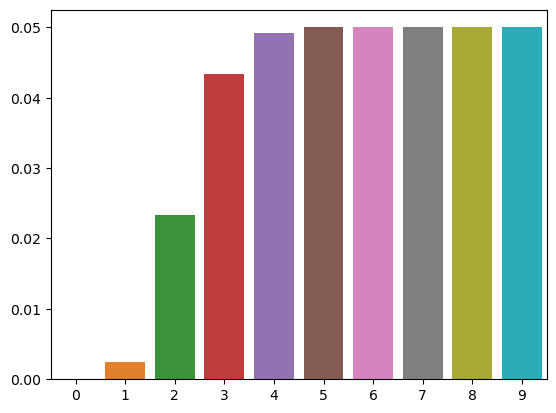

In [124]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': []
}

by_order = RESULTS[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

for order in by_order.index:
    truths: np.ndarray = by_order[by_order.index == order]['language_truth'].values
    preds: np.ndarray = by_order[by_order.index == order]['language_pred'].values
    truths: list = truths[0]
    preds: list = preds[0]
    running_accuracy = 0
    accuracy = accuracy_score(y_true=truths,y_pred=preds)
    order_results['order'].append(order)
    order_results['accuracy'].append(accuracy)

sns.barplot(data=order_results, x='order', y='accuracy')

In the plot above we see the aggregate accuracy per n_gram model. The x axis represents the amount of history, or words, the model has as context. The y axis represents the aggregate accuracy for all models, regardless of language. This metric could be skewed given some models behave better than others. Let's break down the accuracy by order and by language.

#### Accuracy by language and order

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

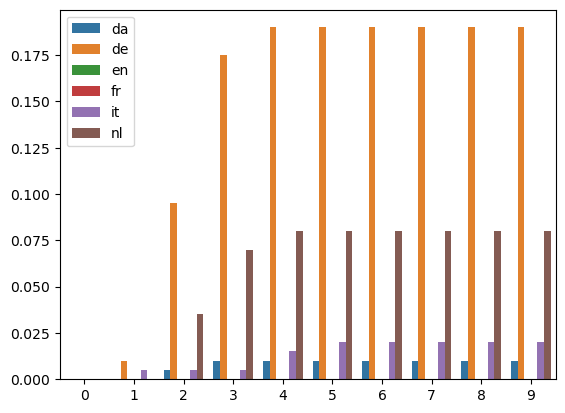

In [125]:
# break down accuracy by order and language
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': [],
    'language': []
}

languages = ['da', 'de', 'en', 'fr', 'it', 'nl']

for order in by_order.index:
    for language in languages:
        language_results = RESULTS[RESULTS['language_truth'] == language]
        by_order = language_results[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

        truths: np.ndarray = by_order[by_order.index == order]['language_truth'].values
        preds: np.ndarray = by_order[by_order.index == order]['language_pred'].values
        truths: list = truths[0]
        preds: list = preds[0]
        running_accuracy = 0
        for i in range(len(truths)):
            running_accuracy += int(truths[i] == preds[i])
        accuracy = running_accuracy / len(truths)
        order_results['order'].append(order)
        order_results['accuracy'].append(accuracy)
        order_results['language'].append(language)

sns.barplot(data=order_results, x='order', y='accuracy', hue='language')

The plot above shows the accuracy of each language model increasing as the number of available context (words) increases. The plot indicates the best model is DE. This is not the case. What's happening here is the model not finding a probability for the history given and yielding the constant 1.0e-7, hence a consistent score for models of order 4 and above.

#### Perplexity scores by language

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

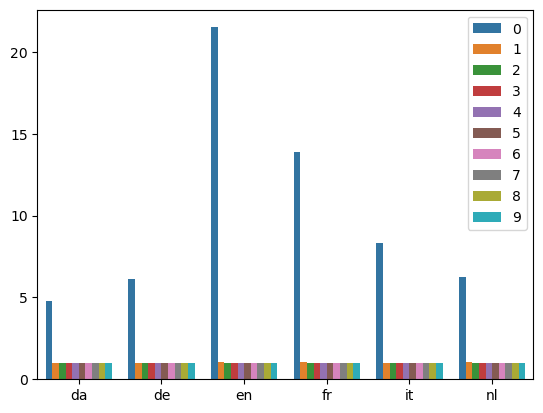

In [132]:
import seaborn as sns
perplexity_by_language = RESULTS[['language_truth', 'order', 'perplexity_score']].groupby(['language_truth', 'order']).mean()

results = {}
results['language_truth'] = [lang[0] for lang in perplexity_by_language.index]
results['perplexity_score'] = perplexity_by_language['perplexity_score'].values
results['order'] = [lang[1] for lang in perplexity_by_language.index]

sns.barplot(data=results, x='language_truth', y='perplexity_score', hue='order')

This plot is as expected, we have constant values for perplexity scores. If no word is found in the history, we add a very small number. This tells me that even though the model was trained on the datasets provided, the sentences provided in the test file were not commonly seen in the test files.

It makes sense for the letter language models to have variable perplexity scores given predicting the next letter in a word given n number of tokens is probabilistically easier than predicting the next word. 

Due to this model being a naive probabilistic model, the only way to obtain a more robust model would be to train it on more data. Why don't we test this hypothesis? The less data a probabilistic model has during training the poorer it will perform. Let's train a model on english and see how it performs on other languages.

#### Training word model on more corpus

In [9]:
# download corpora
import nltk
from nltk.corpus import (
    brown, 
    movie_reviews, 
    product_reviews_2,
    twitter_samples
)

nltk.download('brown')
nltk.download('twitter_samples')
nltk.download('movie_reviews')
nltk.download('product_reviews_2')

sentences = []
sentences.extend(brown.sents())
sentences.extend([word_tokenize(tweet) for tweet in twitter_samples.strings()])
sentences.extend(movie_reviews.sents())
sentences.extend(product_reviews_2.sents())

print(f'Using {len(sentences)} sentences from 4 sources as training data')

[nltk_data] Downloading package brown to /Users/adavila/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/adavila/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/adavila/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package product_reviews_2 to
[nltk_data]     /Users/adavila/nltk_data...
[nltk_data]   Package product_reviews_2 is already up-to-date!


Using 156327 sentences from 4 sources as training data


Given the data is a list of lists where each list is a tokenized sentence, let's rewrite the training function to accept a list of tokenized sentences.

In [7]:
def train_word_lm_large(sentences, order=4):
    lm = defaultdict(Counter)
    for s in tqdm.tqdm(sentences):
        # s = word_tokenize(s) - assuming it's already tokenized
        pad = ['~']*order
        for j in range(len(s)):
            pad.extend([s[j]])
            data:list[str] = pad
            for i in range(len(data)-order):
                history, word = data[i: i+order], data[i+order]
                lm[" ".join(history)][word]+=1

    outlm = {hist:normalize(words) for hist, words in lm.items()}
    return outlm


In [10]:
# let's train 30 (ngrams 1-5 and 6 languages) language models
# ...hopefully it's not too expensive
import tqdm

large_models = {}
languages = ['de', 'da', 'en', 'fr', 'it', 'nl']


for order in tqdm.tqdm(range(2)):
    language_models = {}
    for language in languages:
        language_models[language] = train_word_lm_large(
                                        sentences=sentences, 
                                        order=order
                                    )
    large_models[order] = language_models


100%|██████████| 2/2 [02:00<00:00, 60.14s/it]


Now that the models have been trained, let's test our test data. I'm certain all models will perform poorly except english. Nevertheless, I expect the english model to have improved drastically.

In [11]:
test_data:list[str] = open('./lab2/test.txt').readlines()

def get_metrics_large(metrics: pd.DataFrame):
        """
        Print metrics for a given test suite
        """
        from sklearn.metrics import accuracy_score
        languages = ['da', 'de', 'en', 'fr', 'it', 'nl']
        for language in languages:
            local_metrics = metrics[metrics['language_truth'] == language]
            accuracy = accuracy_score(y_true=local_metrics['language_truth'], y_pred=local_metrics['language_pred'])
            print(f"Model {language} has accuracy {accuracy*100}% with {accuracy*len(local_metrics)} out of {len(local_metrics)}")


LARGE_RESULTS = pd.DataFrame()
scores = []
for order in range(2):
    n_gram_metrics, score = test_ngram_model_word(test_data, order=order, ngram_models=large_models[order])
    print(f'***Model {order+1}***')
    scores.append(score)
    get_metrics_large(n_gram_metrics)
    LARGE_RESULTS = pd.concat([LARGE_RESULTS, n_gram_metrics])

***Model 1***
Model da has accuracy 0.0% with 0.0 out of 200
Model de has accuracy 100.0% with 200.0 out of 200
Model en has accuracy 0.0% with 0.0 out of 200
Model fr has accuracy 0.0% with 0.0 out of 200
Model it has accuracy 0.0% with 0.0 out of 200
Model nl has accuracy 0.0% with 0.0 out of 200
***Model 2***
Model da has accuracy 0.0% with 0.0 out of 200
Model de has accuracy 100.0% with 200.0 out of 200
Model en has accuracy 0.0% with 0.0 out of 200
Model fr has accuracy 0.0% with 0.0 out of 200
Model it has accuracy 0.0% with 0.0 out of 200
Model nl has accuracy 0.0% with 0.0 out of 200


Okay these aren't good results. My intuition tells me more than one model has the same perplexity score, thus making the function spoof us with a "best model". If we plot out the scores, we'll see this behavior. Let's rewrite the function to only take into consideration the english language.

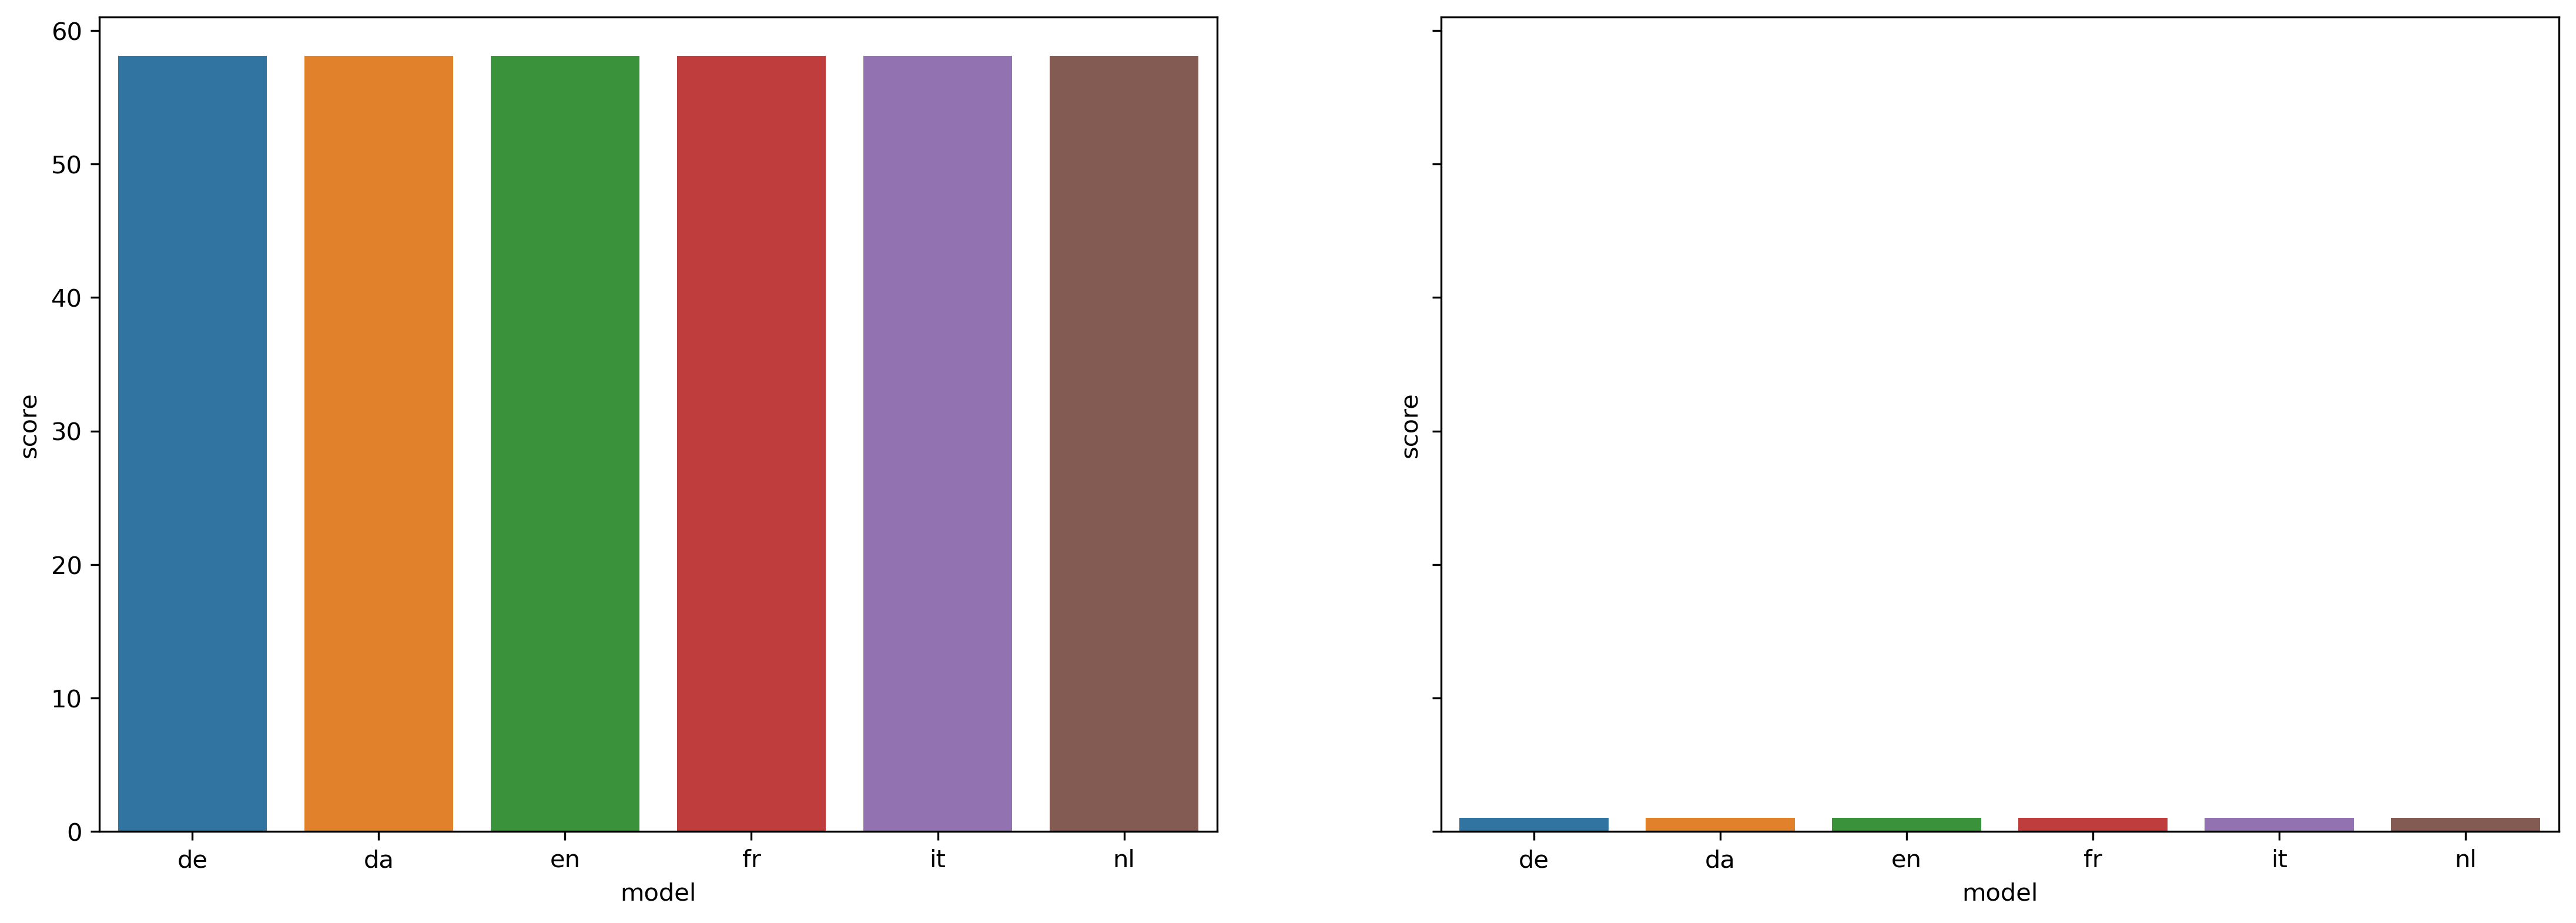

In [25]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
# generate random number to select a run from our test data
random_int = random.randint(0, len(test_data))
# figure, axis = plt.subplots(5, 6)
# print(pd.DataFrame(score[random_int]))
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(18, 6), dpi=300)
for i, score in enumerate(range(0, 2)):
    score = scores[score]
    sns.barplot(
        pd.DataFrame(score[random_int]), 
        x='model', 
        y='score',
        ax=axs[i]
    )

If we run the model on the testing data set we can't really use the accuracy as a metric since the model is only germane to english. Due to this I'm only going to evaluate this model on it's perplexity.

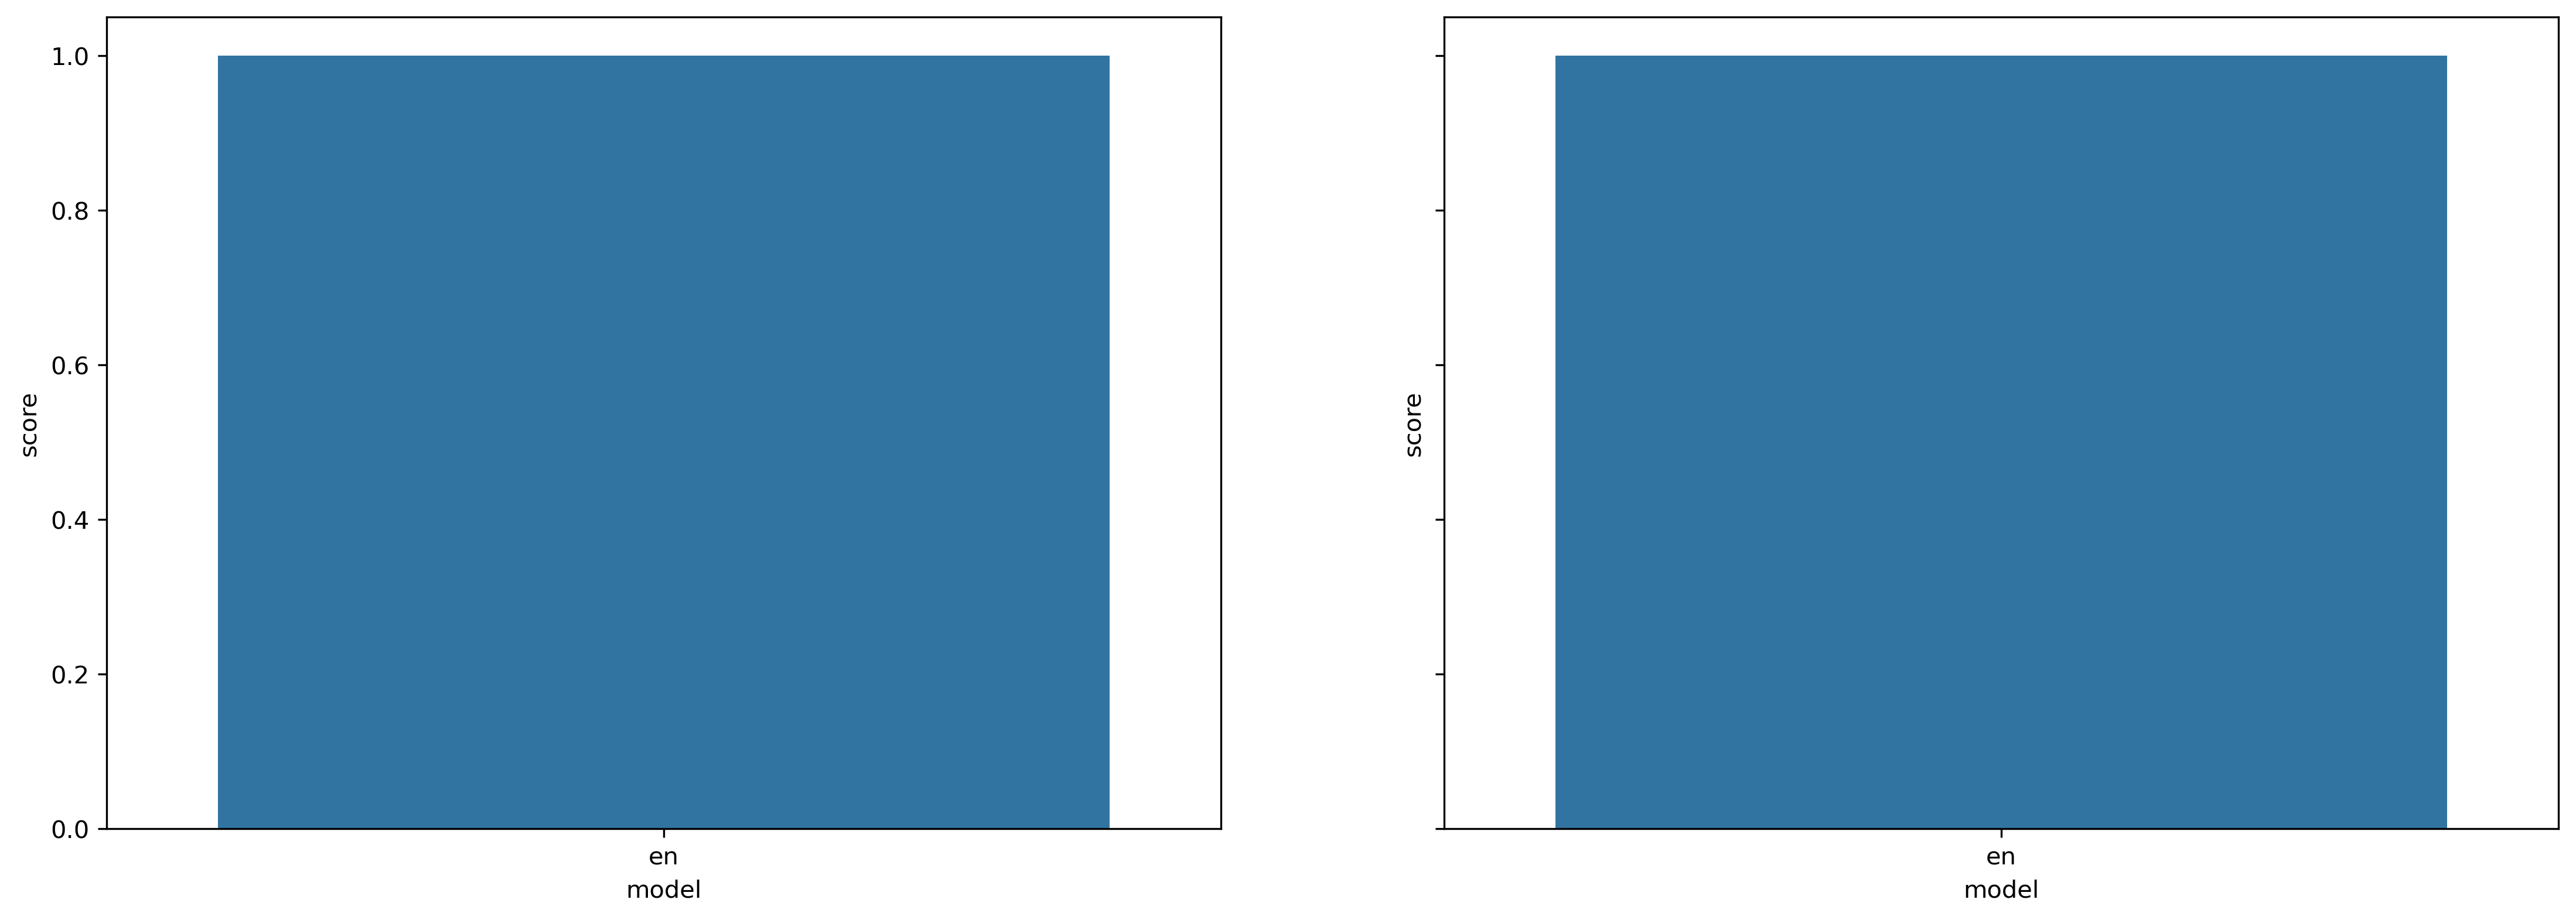

In [31]:
eng_models_larg: list[dict] = [{'en': {key: models.get('en')}} for key, models in large_models.items()]
test_data:list[str] = open('./lab2/test.txt').readlines()


LARGE_RESULTS = pd.DataFrame()
scores = []
for order in range(2):
    n_gram_metrics, score = test_ngram_model_word(test_data, order=order, ngram_models=eng_models_larg[order])
    scores.append(score)
    LARGE_RESULTS = pd.concat([LARGE_RESULTS, n_gram_metrics])

# generate random number to select a run from our test data
random_int = random.randint(0, len(test_data))
# figure, axis = plt.subplots(5, 6)
# print(pd.DataFrame(score[random_int]))
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(18, 6), dpi=300)
for i, score in enumerate(range(0, 2)):
    score = scores[score]
    sns.barplot(
        pd.DataFrame(score[random_int]), 
        x='model', 
        y='score',
        ax=axs[i]
    )

Visualizing just those two models I can speculate the model isn't doing a good job at finding the next word given previous n words. We reject the hypothesis formulated earlier given this naive experiment. This allows me to speculate that a more complex approach might be needed in order to obtain a better model.

#### Word LM for Gender Identification

Let's check if we can use the word lm for gender identification. This might be easier given the training dataset is english. Maybe we can use the big model for this task too.

In [32]:
# train models
import tqdm
gender_models = {}
for order in tqdm.tqdm(range(10)):
    gender_models[order] = {
        'm': train_word_lm(os.path.abspath('./lab2/tennis.train.male.txt'), order),
        'f': train_word_lm(os.path.abspath('./lab2/tennis.train.female.txt'), order),
    }

100%|██████████| 10/10 [15:45<00:00, 94.56s/it] 


In [36]:
from sklearn.metrics import accuracy_score
def test_ngram_model_gender(test_data, order, ngram_models):
    history = {
        'sentence_id': [],
        'perplexity_score': [],
        'language_pred': [],
        'language_truth': [],
        'order': []
    }
    for sentence_index, test in enumerate(test_data):
        # get the text
        gender = test.split('\t')[0].lower()
        text = test.split('\t')[1]

        # iterate over the unigram models
        model_scores  = []
        for model_lang, model in ngram_models.items():
            try:
                score = smoothed_perplexity_word_lm(text, model, order=order)
            except ZeroDivisionError as e:
                score = 0
            model_scores.append({
                'model': model_lang,
                'score': score
            })
        model_scores.sort(key=lambda x: x['score'])
        best_model = model_scores[0]
        history['sentence_id'].append(sentence_index+1)
        history['perplexity_score'].append(best_model.get('score'))
        history['language_pred'].append(best_model.get('model'))
        history['language_truth'].append(gender)
        history['order'].append(order)

    import pandas as pd
    ngram_metrics = pd.DataFrame(history)
    return ngram_metrics

import pandas as pd

def get_metrics_gender(metrics: pd.DataFrame):
    """
    Print metrics for a given test suite
    """
    import numpy as np
    genders = ['m', 'f']
    for gender in genders:
        local_metrics = metrics[metrics['language_truth'] == gender]
        accuracy = accuracy_score(y_true=local_metrics['language_pred'], y_pred=local_metrics['language_truth'])
        # accuracy = np.mean(local_metrics['language_pred'] == local_metrics['language_truth'])
        print(f"Model {gender} has accuracy {accuracy*100}% with {accuracy*len(local_metrics)} out of {len(local_metrics)}")

In [37]:
import time
GENDER_RESULTS = pd.DataFrame()
test_data = open(os.path.abspath('./lab2/tennis.test.txt')).readlines()
for order in tqdm.tqdm(range(ORDER)):
    n_gram_metrics = test_ngram_model_gender(test_data, order=order, ngram_models=gender_models[order])
    print(f'***Model {order+1}***')
    get_metrics_gender(n_gram_metrics)
    GENDER_RESULTS = pd.concat([GENDER_RESULTS, n_gram_metrics])

GENDER_RESULTS.head(2)

 10%|█         | 1/10 [00:59<08:59, 59.99s/it]

***Model 1***
Model m has accuracy 53.47498893315626% with 2416.0 out of 4518
Model f has accuracy 68.9935064935065% with 2550.0 out of 3696


 20%|██        | 2/10 [01:05<03:44, 28.00s/it]

***Model 2***
Model m has accuracy 39.66356795042054% with 1792.0 out of 4518
Model f has accuracy 53.86904761904761% with 1991.0 out of 3696


 30%|███       | 3/10 [01:07<01:53, 16.27s/it]

***Model 3***
Model m has accuracy 37.51660026560425% with 1695.0 out of 4518
Model f has accuracy 52.408008658008654% with 1936.9999999999998 out of 3696


 40%|████      | 4/10 [01:09<01:03, 10.53s/it]

***Model 4***
Model m has accuracy 40.30544488711819% with 1821.0 out of 4518
Model f has accuracy 52.62445887445888% with 1945.0000000000002 out of 3696


 50%|█████     | 5/10 [01:11<00:36,  7.31s/it]

***Model 5***
Model m has accuracy 42.474546259406814% with 1918.9999999999998 out of 4518
Model f has accuracy 53.003246753246756% with 1959.0000000000002 out of 3696


 60%|██████    | 6/10 [01:12<00:21,  5.36s/it]

***Model 6***
Model m has accuracy 44.090305444887115% with 1992.0 out of 4518
Model f has accuracy 51.73160173160173% with 1911.9999999999998 out of 3696


 70%|███████   | 7/10 [01:14<00:12,  4.12s/it]

***Model 7***
Model m has accuracy 45.728198317839755% with 2066.0 out of 4518
Model f has accuracy 52.27272727272727% with 1932.0 out of 3696


 80%|████████  | 8/10 [01:15<00:06,  3.30s/it]

***Model 8***
Model m has accuracy 46.32580787959274% with 2093.0 out of 4518
Model f has accuracy 52.78679653679653% with 1950.9999999999998 out of 3696


 90%|█████████ | 9/10 [01:17<00:02,  2.75s/it]

***Model 9***
Model m has accuracy 46.193005754758744% with 2087.0 out of 4518
Model f has accuracy 52.67857142857143% with 1947.0 out of 3696


100%|██████████| 10/10 [01:19<00:00,  7.91s/it]

***Model 10***
Model m has accuracy 46.23727312970341% with 2089.0 out of 4518
Model f has accuracy 52.62445887445888% with 1945.0000000000002 out of 3696


,sentence_id,perplexity_score,language_pred,language_truth,order
0,1,155.929957,f,m,0
1,2,281.481961,m,m,0


We can see the models are actually producing metrics. Let's visualize the aggregate accuracy.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

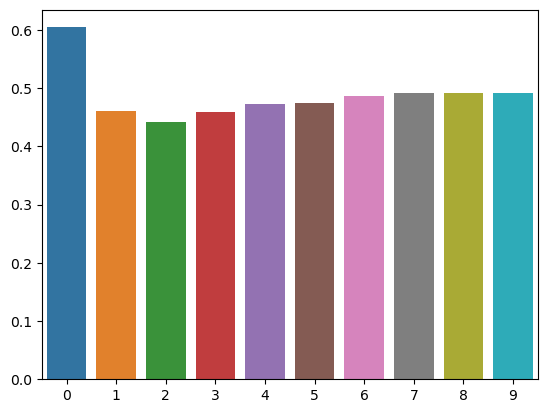

In [39]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': []
}

by_order = GENDER_RESULTS[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

for order in by_order.index:
    truths: np.ndarray = by_order[by_order.index == order]['language_truth'].values
    preds: np.ndarray = by_order[by_order.index == order]['language_pred'].values
    truths: list = truths[0]
    preds: list = preds[0]
    running_accuracy = 0
    accuracy = accuracy_score(y_true=truths,y_pred=preds)
    order_results['order'].append(order)
    order_results['accuracy'].append(accuracy)
    

sns.barplot(data=order_results, x='order', y='accuracy')

Wow! This plot shows us a unigram model has a higher aggregate accuracy over all other ngram models. My intuition told me a model with a higher order would be more accurate than one with a lower order. Let's see which model at each ngram yields a higher accuracy.

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: >

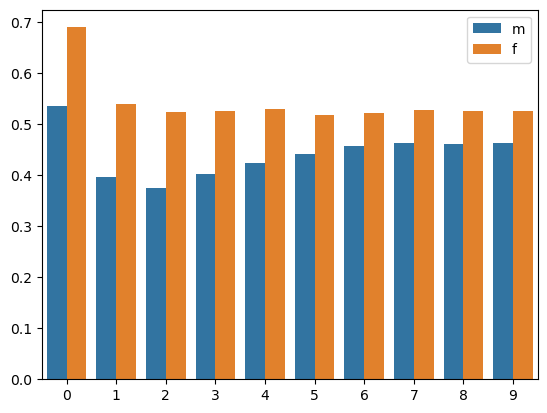

In [41]:
# break down accuracy by order and language
# get accuracy by order
order_results = {
    'order': [],
    'accuracy': [],
    'language': []
}

genders = ['m', 'f']
by_order = GENDER_RESULTS[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

for order in by_order.index:
    for language in genders:
        language_results = GENDER_RESULTS[GENDER_RESULTS['language_truth'] == language]
        by_order = language_results[['language_truth', 'language_pred', 'order']].groupby('order').agg(list)

        truths: np.ndarray = by_order[by_order.index == order]['language_truth'].values
        preds: np.ndarray = by_order[by_order.index == order]['language_pred'].values
        truths: list = truths[0]
        preds: list = preds[0]
        running_accuracy = 0
        for i in range(len(truths)):
            running_accuracy += int(truths[i] == preds[i])
        accuracy = running_accuracy / len(truths)
        order_results['order'].append(order)
        order_results['accuracy'].append(accuracy)
        order_results['language'].append(language)
sns.barplot(data=order_results, x='order', y='accuracy', hue='language')

The models aren't doing too bad for detecting questions directed at women. Now this is only for accuracy. As we've learned in this module, we can measure how good a language model is by its perplexity. Let's break down the graph but by perplexity rather than accuracy.

<Axes: xlabel='language_truth', ylabel='perplexity_score'>

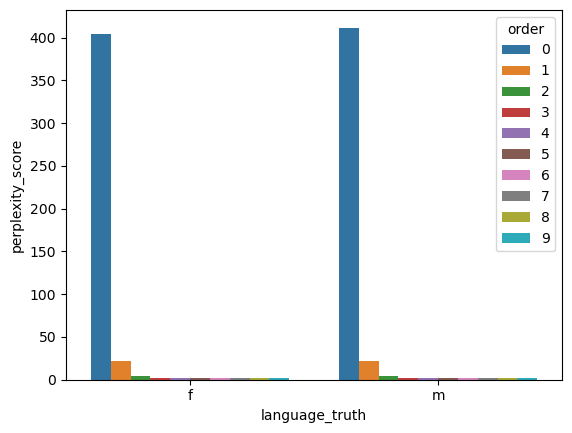

In [42]:
import seaborn as sns
perplexity_by_gender = GENDER_RESULTS[['language_truth', 'order', 'perplexity_score']].groupby(['language_truth', 'order']).mean()
perplexity_by_gender['language_truth'] = [gender[0] for gender in perplexity_by_gender.index.values]
perplexity_by_gender['order'] = [gender[1] for gender in perplexity_by_gender.index.values]

sns.barplot(data=perplexity_by_gender, x='language_truth', y='perplexity_score', hue='order')

The graph shows us an inverse relationship between the order and the average perplexity score. Intuitively this makes sense. A lower perplexity score describes a more confident model. If a model has more context, it's reasonable to assume it will be more confident in predicting the next word. Those models with an order of one cannot confidently predict the next work...yet they were the ones with the highest accuracy

This concludes the lab where we explored the following Markov models
- Letter ngram model
- Word ngram model

The letter ngram models performed better when detecting languages, yet a word model is better at detecting genders given a corpus of documents. We also explored training a large word model for language detection by training the model on a much larger corpus for English. We saw the model didn't yield better results, alluding to the need of a more sophisticated approach.